# Variational Estimation for a Transition Mixture Model

This demo extends the hidden Markov model estimation demo. We consider a generative model with hidden states $s = (s_0, s_1, \dots, s_T)$, whose transitions are governed by transition probability matrices $A_l$ and $A_r$. The state transition probability matrix (at each time $t$) is selected by variables $z = (z_1, \dots, z_T)$. The state relates to observations $x = (x_1, \dots, x_T)$ through an observation probability matrix $B$. We then define the generative model:
\begin{align*}
    s_t &\sim \mathcal{C}at(A_l s_{t-1})^{z_{t,l}}\, \mathcal{C}at(A_r s_{t-1})^{z_{t,r}},\\
    x_t &\sim \mathcal{C}at(B s_t).\\
\end{align*}

We assume three possible states ("red", "green" and "blue"), and the goal is to estimate the transition matrices $A_l$ and $A_r$ from a simulated data set.

## Generate data set

We simulate a sequence of observations by fixing $z, A_l, A_r$ and $B$ and sampling from the generative model. Specifically, we construct $A_l$ such that the only possible state transitions are "green" -> "red", "red" -> "blue", "blue" -> "green", and $A_r$ in the reverse order.
Observation probability matrix $B$ is chosen such that the state is observed under some transition noise.

In [1]:
using ForneyLab

n_samples = 100

# Transition probabilities (some transitions are impossible)
A_l_data = [0.3 0.0 0.7; 0.7 0.3 0.0; 0.0 0.7 0.3]
A_r_data = [0.3 0.7 0.0; 0.0 0.3 0.7; 0.7 0.0 0.3]
A_data = [A_l_data, A_r_data]

# Observation noise
B_data = [0.98 0.01 0.01; 0.01 0.98 0.01; 0.01 0.01 0.98]

s_0_data = [1.0, 0.0, 0.0] # Initial state

# Generate some data
z_data = [zeros(Int64, Int64(n_samples/2)); ones(Int64, Int64(n_samples/2))] # First left, then right
s_data = Vector{Vector{Float64}}(undef, n_samples)
x_data = Vector{Vector{Float64}}(undef, n_samples)
s_t_min_data = s_0_data
for t = 1:n_samples
    a = A_data[z_data[t]+1]*s_t_min_data
    s_data[t] = sample(ProbabilityDistribution(Categorical, p=a./sum(a))) # Simulate state transition
    b = B_data*s_data[t]
    x_data[t] = sample(ProbabilityDistribution(Categorical, p=b./sum(b))) # Simulate observation
    
    s_t_min_data = s_data[t]
end
;

## Model specification

In our model we assume a relatively strong prior on the observation probability matrix, expressing the prior knowledge that we are most likely to observe the true state. On the other hand, we assume an uninformative prior on the state transition matrix, expressing no prior knowledge about transition probabilities and structure.

In [2]:
fg = FactorGraph()

@RV A_l ~ Dirichlet(placeholder(:a_A_l, dims=(3,3))) # Vague priors on transition matrices with symmetry breaking
@RV A_r ~ Dirichlet(placeholder(:a_A_r, dims=(3,3)))
@RV s_0 ~ Categorical(1/3*ones(3))

z = Vector{Variable}(undef, n_samples) # one-hot coding
s = Vector{Variable}(undef, n_samples)
x = Vector{Variable}(undef, n_samples)
s_t_min = s_0
for t = 1:n_samples
    @RV z[t] ~ Categorical(placeholder(:p_z, index=t, var_id=:p_z_*t, dims=(2,)))
    @RV s[t] ~ TransitionMixture(s_t_min, z[t], A_l, A_r)
    @RV x[t] ~ Transition(s[t], placeholder(:B, var_id=:B_*t, dims=(3,3)))
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t, dims=(3,))
end;

## Algorithm generation

We will generate a VMP algorithm to perform inference under the following structured posterior factorization:

\begin{align*}
    q(s, z, A_l, A_r) = q(s, z)\times q(A_l)\times q(A_r)\,.
\end{align*}

In [3]:
# Generate VMP algorithm with free energy
q = PosteriorFactorization([s_0; s; z], A_l, A_r, ids=[:SZ, :AL, :AR])
algo = messagePassingAlgorithm(z, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code));

## Execution

In order to facilitate symmetry breaking between the transition matrices, we assume that the selector priors are (somewhat) informed.

In [4]:
# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}(
    :A_l => vague(Dirichlet, (3,3)),
    :A_r => vague(Dirichlet, (3,3)))

# Initialize data and priors
p_z_vec = [abs.(0.55.-[z_t, 1-z_t]) for z_t in z_data] # Biased selector priors
data = Dict(:x => x_data,
            :a_A_l => ones(3,3),
            :a_A_r => ones(3,3),
            :p_z => p_z_vec,
            :B => B_data)

# Run algorithm
n_its = 20
F = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepSZ!(data, marginals) #, messages_sz)
    stepAL!(data, marginals) #, messages_al)
    stepAR!(data, marginals) #, messages_ar)

    F[i] = freeEnergy(data, marginals)
end
;

## Results

To validate convergence of the inference algorithm, we can inspect the free energy over iterations.

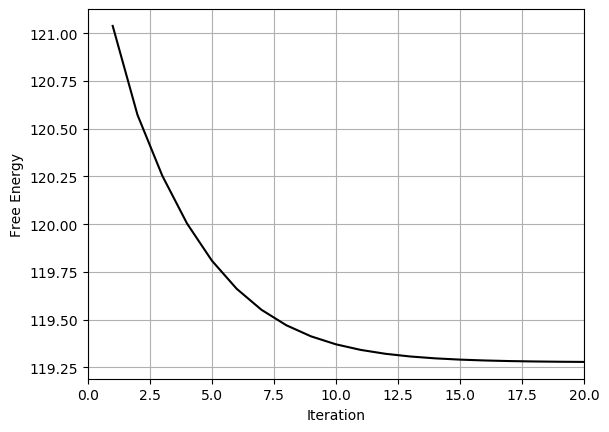

In [5]:
using PyPlot

# Plot free energy
plot(1:n_its, F, color="black")

grid("on")
xlabel("Iteration")
ylabel("Free Energy")
xlim(0,n_its);

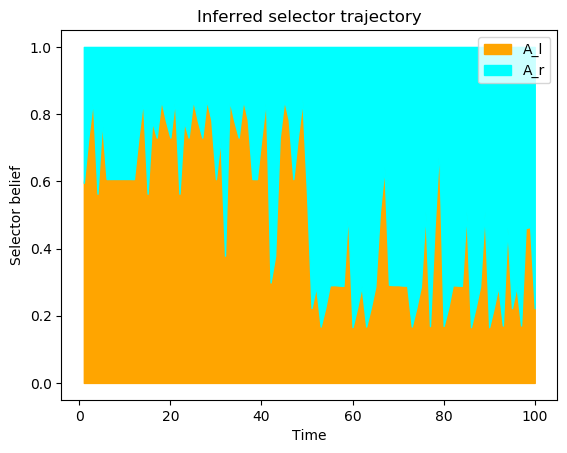

In [6]:
# Plot selector beliefs
p_z = [marginals[:z_*t].params[:p][1] for t=1:n_samples]
fill_between(1:n_samples, zeros(n_samples), p_z, color="orange", label="A_l")
fill_between(1:n_samples, p_z, ones(n_samples), color="cyan", label="A_r")
xlabel("Time")
ylabel("Selector belief")
legend()
title("Inferred selector trajectory")
;

We can also compare the estimated state transition probabilities to the true ones using a heatmap:

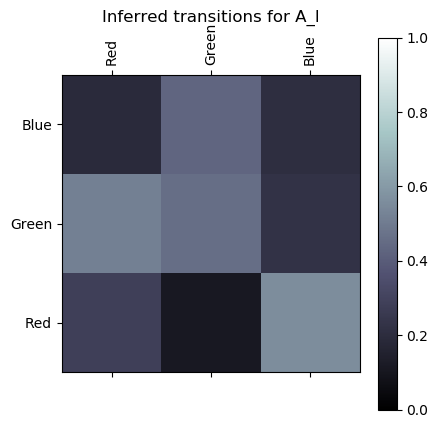

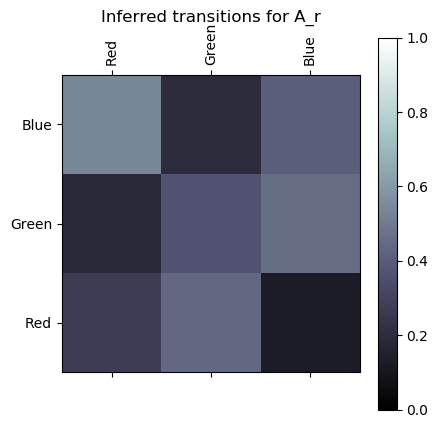

In [7]:
# Inferred state transition probabilities for A_l
PyPlot.plt.matshow(mean(marginals[:A_l]), cmap="bone", vmin=0.0, vmax=1.0)
ttl = title("Inferred transitions for A_l")
ttl.set_position([.5, 1.15])
yticks([0, 1, 2], ["Red", "Green", "Blue"])
xticks([0, 1, 2], ["Red", "Green", "Blue"], rotation="vertical")
ylim(-0.5, 2.5)
colorbar()

# Inferred state transition probabilities for A_r
PyPlot.plt.matshow(mean(marginals[:A_r]), cmap="bone", vmin=0.0, vmax=1.0)
ttl = title("Inferred transitions for A_r")
ttl.set_position([.5, 1.15])
yticks([0, 1, 2], ["Red", "Green", "Blue"])
xticks([0, 1, 2], ["Red", "Green", "Blue"], rotation="vertical")
ylim(-0.5, 2.5)
colorbar();